In [1]:
import jax

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

import equinox
import numpy as np
import scipy.stats
from jax import numpy as jnp
from matplotlib.figure import Figure
from tqdm.notebook import trange

%matplotlib inline

In [2]:
import os
import sys

lib_path = os.path.join(os.path.curdir, "src")
sys.path.insert(0, lib_path)

In [4]:
import importlib

import kalman_diagnostics
import neural_kalman
import normal
import probit_network
import random_matrix
import unscented

importlib.reload(neural_kalman)
importlib.reload(kalman_diagnostics)
importlib.reload(unscented)
importlib.reload(normal)
importlib.reload(random_matrix)
importlib.reload(probit_network)
from normal import Normal
from probit_network import ProbitLinear, ProbitLinearNetwork
from random_matrix import RandomGaussian, RandomOrthogonalProjection, ZeroMatrix

In [5]:
key = jax.random.PRNGKey(123)

In [6]:
def ccf(*eigenvalues):
    """
    Generate the controllable canonical form (companion matrix) A
    for a system with the given eigenvalues.

    Parameters:
        *eigenvalues: Variable length argument list of eigenvalues (lambda1, lambda2, ..., lambdan)

    Returns:
        A: The controllable canonical form matrix (n x n)
    """
    # Ensure input is treated as a flat list
    eigenvalues = np.array(eigenvalues)

    # Compute the coefficients of the characteristic polynomial
    # The polynomial has the form: s^n + a_{n-1}s^{n-1} + ... + a_1 s + a_0
    poly_coeffs = np.poly(eigenvalues)  # Gives [1, a_{n-1}, ..., a_0]

    # Remove the leading 1 (coefficient of s^n)
    a_coeffs = -poly_coeffs[1:]  # Negative signs for canonical form

    n = len(a_coeffs)
    A = np.zeros((n, n))

    # Fill the last row with the negative coefficients
    A[-1, :] = a_coeffs[::-1]

    # Fill the subdiagonal with 1s
    for i in range(n - 1):
        A[i, i + 1] = 1

    return jnp.array(A)

In [7]:
key, key1, key2, key3, key4 = jax.random.split(jax.random.PRNGKey(21), 5)

n_x = 4
n_u = 1
n_y = 2

n_hidden_output = 100

F = ProbitLinearNetwork(
    ProbitLinear(
        in_size=n_x + n_u,
        out_size=n_x,
        key=key2,
        A=jnp.hstack((ccf(0.99, 0.99, 0.7, -0.8), jnp.zeros((n_x, 1)).at[-1].set(1))),
        b=ZeroMatrix(),
        C=ZeroMatrix(),
        d=ZeroMatrix(),
    ),
)
H = ProbitLinearNetwork(
    ProbitLinear.create_probit(
        in_size=n_x + n_u,
        out_size=n_hidden_output,
        key=key3,
        A=RandomOrthogonalProjection(1e0),
        b=RandomOrthogonalProjection(1e0),
    ),
    ProbitLinear.create_probit(
        in_size=n_hidden_output,
        out_size=n_y,
        key=key4,
        A=RandomOrthogonalProjection(1e0),
        b=ZeroMatrix(),
    ),
)
H_aug = H.augment_with_identity()

In [8]:
x = F(np.zeros(n_x + n_u))

In [9]:
sim_horizon = 200
Q = jnp.eye(n_x) * 1e-2
R = jnp.eye(n_y) * 1e-4

In [10]:
η_key, ϵ_key = jax.random.split(key, 2)

In [11]:
η = jax.random.multivariate_normal(
    mean=jnp.zeros(n_x), cov=Q, key=η_key, shape=sim_horizon
)

In [12]:
ϵ = jax.random.multivariate_normal(
    mean=jnp.zeros(n_y), cov=R, key=ϵ_key, shape=sim_horizon
)

In [13]:
u = np.zeros((sim_horizon, n_u))
u[100:] = 10

In [14]:
x = np.zeros((sim_horizon, n_x))
y = np.zeros((sim_horizon, n_y))
y_noiseless = np.zeros((sim_horizon, n_y))
for i in range(1, sim_horizon):
    x[i, :] = F(np.concatenate((x[i - 1, :], u[i - 1, :]))) + η[i - 1]
    y_noiseless[i, :] = H(np.concatenate((x[i, :], u[i - 1,])))
    y[i, :] = y_noiseless[i, :] + ϵ[i]

Preview input, state, and output trajectories

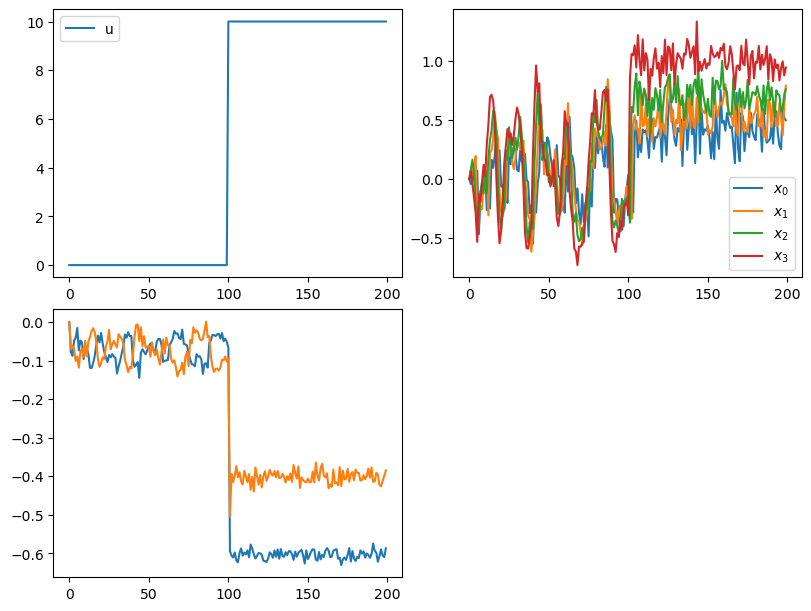

In [15]:
fig = Figure(figsize=(8, 6), dpi=100, constrained_layout=1)
ax = fig.add_subplot(221)
ax.plot(u[:, 0], label="u")
ax.legend()
ax = fig.add_subplot(222)
for i in range(n_x):
    ax.plot(x[:, i], label=rf"$x_{i}$")
ax.legend()
ax = fig.add_subplot(223)
for i in range(n_y):
    ax.plot(y[:, i], label=rf"$y_{i}$")
# ax.legend()
fig

In [16]:
method = "analytic"
# method = "linear"
# method = "unscented"

In [17]:
kalman = neural_kalman.NeuralKalmanFilter(n_x=n_x, n_u=n_u, n_y=n_y, F=F, H=H, Q=Q, R=R)

In [18]:
x_0 = Normal.standard(n_x)
u_0 = Normal.standard(n_u)

In [19]:
x_and_y = kalman.predict_with_input(x_0, u_0)

In [20]:
predicted = [x_0]
filtered = [x_0]
for i in trange(1, sim_horizon):
    x_and_y_pred = kalman.predict_with_input(
        filtered[i - 1], Normal.certain(u[i]), method=method
    )
    predicted.append(x_and_y_pred)
    x_filtered = kalman.correct(x_and_y_pred, y[i])
    filtered.append(x_filtered)

  0%|          | 0/199 [00:00<?, ?it/s]

In [21]:
diagnostics = kalman_diagnostics.KalmanDiagnostics(kalman, x, slice(1, None))

In [22]:
print("prediction RMSE", diagnostics.point_rmse(predicted))
print("filtering RMSE ", diagnostics.point_rmse(filtered))

prediction RMSE 0.1568469769878018
filtering RMSE  0.15040309587417924


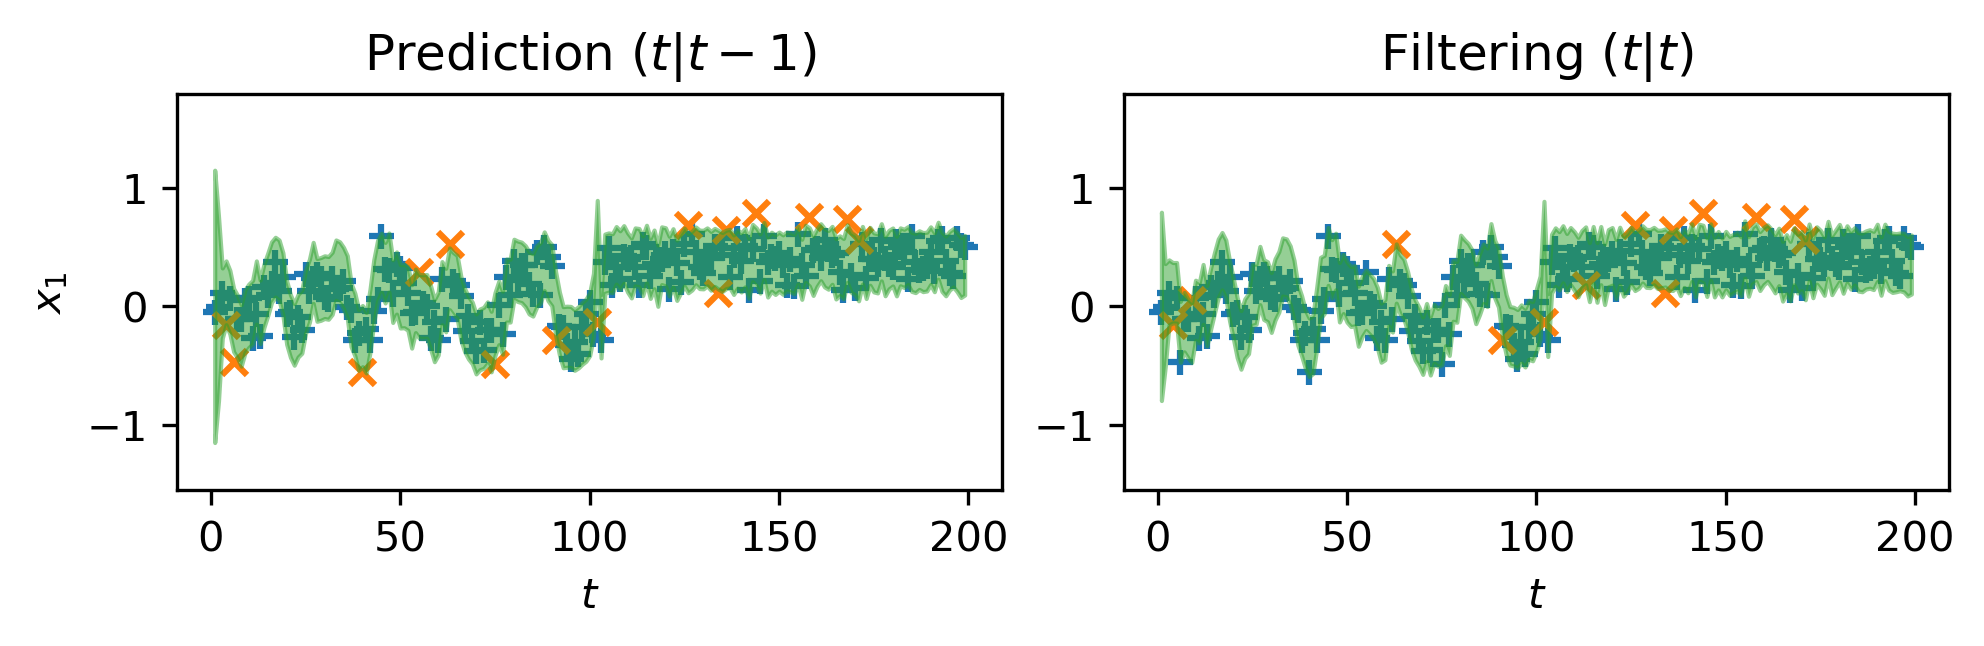

In [23]:
fig = Figure(figsize=(12, 6), dpi=300, constrained_layout=1)
for i in [0]:
    for j, (state_trajectory, desc) in enumerate(
        [
            (predicted, "Prediction $(t|t-1)$"),
            (filtered, "Filtering $(t|t)$"),
            # (x_smoothed, P_smoothed, "Smoothing $(t|T)$"),
        ]
    ):
        # prepare and decorate axes
        ax = fig.add_subplot(4, 4, 4 * i + j + 1)
        if j == 0:
            ax.set_ylabel(rf"$x_{i+1}$")
        else:
            pass  # ax.set_yticks([])
        if i == 0:
            ax.set_title(desc)
        if i == 0:
            ax.set_xlabel(rf"$t$")
        else:
            ax.set_xticks([])
        # get data to plot
        times, state, _mean, lower, upper, covered, missed = (
            diagnostics.plot_state_trajectories(state_trajectory, i, coverage=0.95)
        )
        # plot data
        ax.set_ylim(min(state) - 1, max(state) + 1)
        ax.scatter(
            times[covered],
            state[covered],
            color="C0",
            marker="+",
        )
        ax.scatter(
            times[missed],
            state[missed],
            color="C1",
            marker="x",
        )
        ax.fill_between(
            times,
            lower,
            upper,
            color="C2",
            alpha=0.5,
        )
fig